In [0]:
'''
Gensim Doc2Vec
'''
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import random
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import gensim
import sklearn.metrics

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
################################
################################
################################
#Load Data

SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

import pickle
with open('/content/drive/My Drive/CS 263 Project/baking_data_title_ingredients.pickle','rb') as f:
    baking_data = pickle.load(f)

cleaned_recipes = baking_data[1]
cleaned_recipes_IDs = baking_data[9]

In [0]:
MAX_LENGTH = 75
cleaned_recipes_IDs = [cleaned_recipes_IDs[i] for i in range(0,len(cleaned_recipes)) if len(cleaned_recipes[i].split())<= MAX_LENGTH]
cleaned_recipes = [cleaned_recipes[i] for i in range(0,len(cleaned_recipes)) if len(cleaned_recipes[i].split())<= MAX_LENGTH]
len(cleaned_recipes_IDs)
len(cleaned_recipes)

129375

In [0]:
cleaned_recipes[0]

'zucchini nut bread --|||-- flour || cinnamon || bake soda || salt || bake powder || egg || sugar || veget oil || vanilla || raw zucchini || walnut'

In [0]:
###############
###############
###############
###############
#doc2vec embeddings
#https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

#Preprocess Text
def create_corpus(dta, tokens_only=False):
    for i, line in enumerate(dta):
        tokens = line
        #tokens = gensim.utils.simple_preprocess(line)
        #tokens = [w for w in tokens if w.isalpha() and not w in stopwords.words('english')]
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

corpus = list(create_corpus(cleaned_recipes))
#test_corpus = list(create_corpus(cleaned_recipes[100000:], tokens_only=True))
corpus2 = list(create_corpus(cleaned_recipes, tokens_only=True))

In [0]:
print(corpus[0])
print(len(corpus))

TaggedDocument(zucchini nut bread --|||-- flour || cinnamon || bake soda || salt || bake powder || egg || sugar || veget oil || vanilla || raw zucchini || walnut, [0])
129375


In [0]:
#define model, get vocab, and train model
hidden_size = 512
model = gensim.models.doc2vec.Doc2Vec(vector_size=hidden_size, min_count=1, epochs=20)

In [0]:
model.build_vocab(corpus)

In [0]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [0]:
#Save model
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("/content/drive/My Drive/CS 263 Project/doc2vec_model")
model.save(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#load model
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("/content/drive/My Drive/CS 263 Project/doc2vec_model")
model = gensim.models.doc2vec.Doc2Vec.load(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#get embeddings
import numpy as np
embeddings = np.empty([len(corpus),hidden_size])
for i in range(len(corpus)):
  embeddings[i,:] = model.infer_vector(corpus2[i])
embeddings.shape

(129375, 512)

In [0]:
#get embeddings for recipies with nutritional info
with open('/content/drive/My Drive/CS 263 Project/nutritional_info.pickle','rb') as f:
    nutritional_info = pickle.load(f)

embeddings_IDs = [cleaned_recipes_IDs[i] for i in range(0,len(cleaned_recipes_IDs)) if len(cleaned_recipes[i].split())<= MAX_LENGTH]
nutri_embeddings_indices = [i for i, val in enumerate(embeddings_IDs) if val in nutritional_info["id"].tolist()]

nutri_embeddings_IDs = [embeddings_IDs[i] for i in nutri_embeddings_indices]
nutri_embeddings = [embeddings[i] for i in nutri_embeddings_indices]

In [0]:
#similarity matrix
cosine_similarities = sklearn.metrics.pairwise.cosine_similarity(nutri_embeddings, Y=None, dense_output=False)
print(cosine_similarities)
print(np.isnan(cosine_similarities).any())
print(np.isfinite(cosine_similarities).any())

[[ 1.          0.15733758  0.06637765 ... -0.2255604  -0.16650057
  -0.03081606]
 [ 0.15733758  1.          0.19599518 ...  0.65783535  0.17117983
   0.68227973]
 [ 0.06637765  0.19599518  1.         ...  0.22371617 -0.14103138
   0.26503397]
 ...
 [-0.2255604   0.65783535  0.22371617 ...  1.          0.18861771
   0.81861439]
 [-0.16650057  0.17117983 -0.14103138 ...  0.18861771  1.
  -0.00847169]
 [-0.03081606  0.68227973  0.26503397 ...  0.81861439 -0.00847169
   1.        ]]
False
True


In [0]:
import pickle
similarity_pickle = [nutri_embeddings,nutri_embeddings_IDs,cosine_similarities]
with open('/content/drive/My Drive/CS 263 Project/doc2vec_similarity.pickle', 'wb') as f:
    pickle.dump(similarity_pickle, f)

Analysis

In [0]:
#Affinity Clustering on sim matrix
from sklearn.cluster import AffinityPropagation
import numpy as np
clustering = AffinityPropagation(affinity="precomputed",verbose=True).fit(cosine_similarities)
cluster_centers_indices = clustering.cluster_centers_indices_
labels = clustering.labels_
num_clusters = len(cluster_centers_indices)
print(num_clusters)

Converged after 70 iterations.
267


In [0]:
#spectral clustering on sim matrix
from sklearn.cluster import SpectralClustering
import numpy as np
num_clusters = 10
spec_clust = SpectralClustering(n_clusters=num_clusters, affinity='precomputed')
spec_clust.fit(cosine_similarities + np.random.random())
labels = spec_clust.labels_.tolist()

In [0]:
#PCA on embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=5).fit(nutri_embeddings)
print(pca.explained_variance_ratio_)
pca_2d = pca.transform(nutri_embeddings)

[0.16596268 0.10036383 0.08897636 0.07891116 0.07155533]


In [0]:
#K-Means clustering on embeddings
from sklearn.cluster import KMeans
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(nutri_embeddings)
labels = km.labels_.tolist()

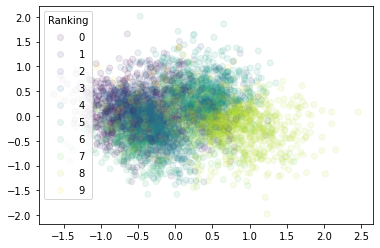

In [0]:
#CLuster Plot
scatter = plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels,alpha=0.1)
plt.legend(*scatter.legend_elements(num=num_clusters),
                    loc="upper left", title="Ranking")
plt.show()

OLD Analysis

In [0]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sim_matrix = cosine_similarities

In [0]:
#check that IDs are in the same order
categories = nutritional_info[["id","category_fat_salt_sugars"]]
nutri_embeddings_IDs_df = pd.DataFrame(nutri_embeddings_IDs)
categories["nutri_embeddings_IDs"] = nutri_embeddings_IDs
categories["match"] = categories["nutri_embeddings_IDs"]==categories["id"]
categories.groupby(['match']).size().reset_index().rename(columns={0:'count'})

In [0]:
#count number of recipes in each category
cluster_data = { 'recipe': nutri_embeddings_IDs, 'cluster': categories["category_fat_salt_sugars"].tolist()}
frame = pd.DataFrame(cluster_data, index = [clusters] , columns = ['recipe', 'cluster'])
frame['cluster'].value_counts()

In [0]:
nutritional_info.head()
nutritional_info.groupby(['fat','salt','sugars','category_fat_salt_sugars']).size().reset_index().rename(columns={0:'count'})

,fat,salt,sugars,category_fat_salt_sugars,count
0,green,green,green,0,192
1,green,green,orange,1,82
2,green,green,red,2,201
3,green,orange,green,3,341
4,green,orange,orange,4,81
5,green,orange,red,5,115
6,green,red,green,6,163
7,green,red,orange,7,40
8,green,red,red,8,68
9,orange,green,green,9,162


In [0]:
#########################################
## K- Means Clustering
#########################################

# K-Means clustering - perform on similarity matrix (try to ID Savory vs. Sweet)
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(sim_matrix)
clusters = km.labels_.tolist()

cluster_data = { 'recipe': nutri_embeddings_IDs, 'cluster': categories["category_fat_salt_sugars"]}
frame = pd.DataFrame(cluster_data, index = [clusters] , columns = ['recipe', 'cluster'])
frame['cluster'].value_counts()

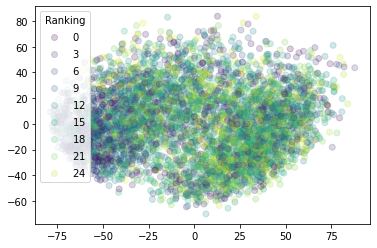

In [0]:
#########################################
## PCA 
#########################################

### PCA
X_std = StandardScaler().fit_transform(sim_matrix)
pca = PCA(n_components=5).fit(X_std)
pca_2d = pca.transform(X_std)
scatter = plt.scatter(pca_2d[:,0], pca_2d[:,1], c=frame.cluster,alpha=0.2)
plt.legend(*scatter.legend_elements(num=10),
                    loc="upper left", title="Ranking")
plt.show()

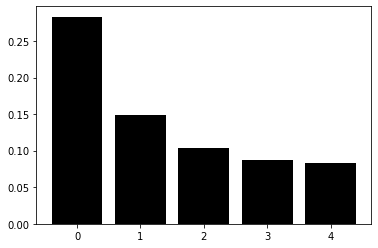

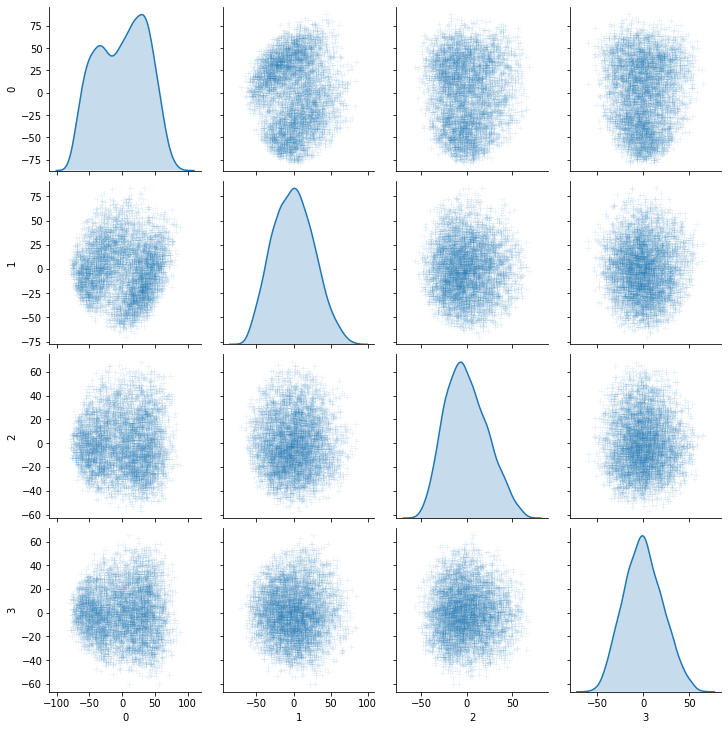

In [0]:
# Scree Plot: Variabiliy explained + visualization
pca.explained_variance_ratio_
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.show()

#plot pairwise PCs
import seaborn as sns
sns.pairplot(pd.DataFrame(pca_2d[:,0:4]), diag_kind="kde", markers="+",plot_kws = {'alpha': 0.1})
plt.show()